# Scaling with timesteps

In [1]:
from jwave.geometry import Domain
from jax import numpy as jnp
from jwave.geometry import Medium,TimeAxis,_points_on_circle, Sensors, _circ_mask
from jwave.acoustics import ongrid_wave_propagation
from timeit import timeit

In [2]:
N, dx = (256, 256), (0.1e-3, 0.1e-3)
domain = Domain(N, dx)
sound_speed = jnp.ones(N)*1500
sound_speed = sound_speed.at[30:200,50:80].set(2500.)
medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=20)

sensors_positions = (jnp.array([35]), jnp.array([40]))
sensors = Sensors(positions=sensors_positions)

mask1 = _circ_mask(N, 8, (100,100))
mask2 = _circ_mask(N, 5, (160,120))
mask3 = _circ_mask(N, 10, (128,128))
mask4 = _circ_mask(N, 30, (128,128))
p0 = 5.*mask1 + 3.*mask2 + 4.*mask3 + 0.5*mask4

In [72]:
time_axis = TimeAxis.from_medium(medium, cfl=0.3, t_end=.05*1.2e-5)

params, j_solver = ongrid_wave_propagation(
    medium=medium,
    time_array=time_axis,
    output_t_axis = time_axis,
    sensors=sensors,
    backprop=False,
    p0 = p0
)

In [73]:
time_axis.to_array().shape

(50,)

In [74]:
_ = j_solver(params)

In [75]:
%timeit j_solver(params).block_until_ready()

14.1 ms ± 68.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
steps = [50, 100, 200, 500, 1000, 2000, 5000, 10000]

# Times in ms
mean_times = [14.1, 20.5, 32,  75,  144, 279, 682, 1340]
std_times =  [0.1,  0.3,  0.4, 0.2, 0.5, 1.8, 2.1, 5.27]

In [77]:
!nvidia-smi

Thu Dec  2 19:06:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   56C    P8     3W / 125W |   7437MiB /  7973MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

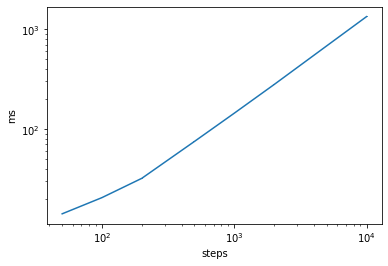

In [78]:
from matplotlib import pyplot as plt

plt.errorbar(steps, mean_times, yerr=std_times)
plt.ylabel("ms")
plt.xlabel("steps")
plt.xscale("log")
plt.yscale("log")